# MLPS - Mercari Price ML

In [1]:
import pandas as pd 
import numpy as np

### Perform data cleaning

In [2]:
data = pd.read_csv("Data/train.tsv", delimiter="\t", index_col=0)

# remove items with out a price
data = data[pd.notna(data["price"])]

data["item_description"] = data["item_description"].replace("No description yet", "")
data["item_description"] = data["item_description"].replace(np.nan, "")

temp = data["category_name"].fillna('').str.split('/')
              
data["category_name_1"] = temp.str[0]
data["category_name_2"] = temp.str[1]
data["category_name_3"] = temp.str[2:].str.join("/")

/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Implement porter stemming in count vectorizer

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.porter import *
import string

class StemmerTokenizer(object):
    def __init__(self):
        self.ps = PorterStemmer()
        self.translator = str.maketrans('', '', string.punctuation + string.digits)
    def __call__(self, doc):
        return [self.ps.stem(w) for w in doc.translate(self.translator).split()]

vectorizer = CountVectorizer(lowercase = True,
                             max_df = .5,
                             min_df = .001,
                             tokenizer = StemmerTokenizer(),
                             stop_words='english')

### Count vectorize the data

In [11]:
%%time
tfm = vectorizer.fit_transform(data["item_description"])

CPU times: user 9min 58s, sys: 3.41 s, total: 10min 1s
Wall time: 10min 3s


In [12]:
# vocab = vectorizer.vocabulary_ 
# removed_words = vectorizer.stop_words_

In [13]:
%%time
tfidf_vectorizer = TfidfTransformer()
tfidf_transformed = tfidf_vectorizer.fit_transform(tfm)

CPU times: user 465 ms, sys: 310 ms, total: 774 ms
Wall time: 791 ms


### Save results for time savings

In [14]:
from scipy.sparse import save_npz
save_npz("tfm.npz", tfm)
save_npz("tfidf_transformed.npz", tfidf_transformed)

### Load files as necessary for time savings

In [3]:
from scipy.sparse import load_npz

tfm = load_npz("tfm.npz")
tfidf_transformed = load_npz("tfidf_transformed.npz")
cleaned_categorical = pd.read_csv('Data/train_clean.tsv', sep='\t', header=0)

In [ ]:
tfm.shape

In [ ]:
tfidf_transformed.shape

In [ ]:
cleaned_categorical.shape

# Split into train and test

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_categorical = cleaned_categorical["price"].astype('float', copy=False)
cleaned_categorical.drop(["train_id", "name", "category_name", "item_description", "price"], axis=1, inplace=True)
cleaned_categorical["item_condition_id"] = cleaned_categorical["item_condition_id"].astype('str', copy=False)

In [5]:
ohe_cleaned_categorical = pd.get_dummies(cleaned_categorical)

In [6]:
y_cat_train, y_cat_test, X_cat_train, X_cat_test, tfidf_train, tfidf_test, tfm_train, tfm_test = train_test_split(
    y_categorical, ohe_cleaned_categorical, tfidf_transformed, tfm, test_size=0.2, random_state=95)

# Split into X and Y and remove unused columns

In [ ]:
ohe_cleaned_categorical.head()

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import GridSearchCV 

# # def modelvalidation(n_split, rand_state):
# #     estimator

# search_range = {"max_depth": [1, 2]}
# folds = 2

# cv = GridSearchCV(estimator=DecisionTreeRegressor(),  cv= folds, param_grid=search_range,  refit=True, n_jobs= -1, verbose=1, return_train_score=True)
# cv.fit(X_cat_train, y_cat_train)  

In [12]:
y_cat_train_small, y_cat_train_remainder, X_cat_train_small, X_cat_train_remainder, tfidf_train_small, tfidf_train_remainder = train_test_split(
        y_cat_train, X_cat_train, tfidf_train, test_size=0.9, random_state=95)


In [13]:
y_cat_train_small.shape

(118602,)

In [14]:
X_cat_train_small.shape

(118602, 5809)

In [15]:
from sklearn.linear_model import LassoCV

model = LassoCV(cv=3, verbose=True).fit(X_cat_train_small, y_cat_train_small)

............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.0min finished


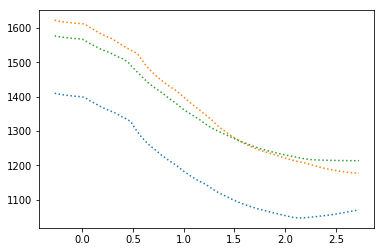

[[1410.19874432 1622.98763508 1577.76854625]
 [1408.62656066 1621.16741626 1576.00279635]
 [1406.97447223 1619.57103442 1574.47131504]
 [1405.53373068 1618.18245321 1573.14330028]
 [1404.27706664 1616.97461513 1571.99198147]
 [1403.18074514 1615.92398636 1570.99409302]
 [1402.22410646 1615.01009782 1570.12941662]
 [1401.38916664 1614.21514607 1569.38038315]
 [1400.66027004 1613.52364607 1568.73172661]
 [1399.7348465  1612.92212931 1567.82454578]
 [1397.14499133 1610.55458207 1562.85068891]
 [1391.04585305 1604.584757   1557.37759279]
 [1385.73042513 1599.1484473  1552.61540091]
 [1380.95475758 1594.140304   1548.26075805]
 [1376.17547258 1588.51827013 1543.37177766]
 [1371.17261376 1583.61936135 1539.00450237]
 [1366.80553436 1579.35002007 1535.09572854]
 [1362.79141411 1575.42596374 1531.63190916]
 [1359.02212562 1571.71484969 1528.29193332]
 [1355.46665771 1567.10756858 1523.35973736]
 [1351.76762495 1561.73671299 1518.74594732]
 [1346.42837648 1555.76652696 1514.75976364]
 [1341.635

In [21]:
import matplotlib.pyplot as plt

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.show()
print(model.mse_path_)